In [1]:
import os
import json
import cv2
import torch

from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
import os
import json
import cv2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

class RGBDGraspDataset(Dataset):
    def __init__(self, datasets):
        """
        Initialize the dataset by combining multiple sources.
        
        Args:
        datasets (list of dict): Each dict contains:
            - 'image_path': Path to RGB images.
            - 'depth_path': Path to depth maps.
            - 'anno_path': Path to JSON annotation file(s).
            - 'image_subdirs': List of subdirectories for images (optional).
        """
        self.data = []
        self.grasp_mapping = {
            "3 jaw chuck": 0,
            "key": 1,
            "pinch": 2,
            "power": 3,
            "tool": 4
            }
        
        for dataset in datasets:
            image_path = dataset['image_path']
            depth_path = dataset['depth_path']
            anno_path = dataset['anno_path']
            subdirs = dataset.get('image_subdirs', None)

            if os.path.isdir(anno_path):
                anno_files = [os.path.join(anno_path, f) for f in os.listdir(anno_path) if f.endswith('.json')]
                annotations = {}
                for file in anno_files:
                    with open(file, 'r') as f:
                        annotations.update(json.load(f))
            else:
                with open(anno_path, 'r') as f:
                    annotations = json.load(f)


            if subdirs:
                for subdir in subdirs:
                    full_image_dir = os.path.join(image_path, subdir)
                    full_depth_dir = os.path.join(depth_path, subdir)
                    for img_file in os.listdir(full_image_dir):
                        if img_file in annotations:
                            rgb_path = os.path.join(full_image_dir, img_file)
                            depth_file = os.path.splitext(img_file)[0] + "_depth.png"
                            depth_filepath = os.path.join(full_depth_dir, depth_file)

                            label = annotations[img_file]["grip"]
                            if os.path.exists(rgb_path) and os.path.exists(depth_filepath):
                                self.data.append((rgb_path, depth_filepath, label))


            else:
                for img_file in os.listdir(image_path):
                    if img_file in annotations:
                        rgb_path = os.path.join(image_path, img_file)
                        depth_file = os.path.splitext(img_file)[0] + "_depth.png"
                        depth_filepath = os.path.join(depth_path, depth_file)

                        label = annotations[img_file]["grip"]
                        if label != 'None':
                            self.data.append((rgb_path, depth_filepath, label))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rgb_path, depth_path, label = self.data[idx]
        
        rgb_image = cv2.imread(rgb_path, cv2.IMREAD_COLOR)
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        rgb_tensor = transform(rgb_image)

        depth_image = cv2.imread(depth_path, cv2.IMREAD_COLOR)[:, :, 0]
        depth_tensor = transform(depth_image)

        label = self.grasp_mapping[label]

        return rgb_tensor, depth_tensor, label

# Example usage
datasets = [
    {
        'image_path': '../data/DeepGrasping_JustImages',
        'depth_path': '../data/DEPTH_DeepGrasping_JustImages',
        'anno_path': '../data/DeepGrasping_Anno',
        'image_subdirs': [f'{i:02}' for i in range(1, 11)],
    },
    {
        'image_path': '../data/Imagenet',
        'depth_path': '../data/DEPTH_Imagenet',
        'anno_path': '../data/Anno_ImageNet.json',
    },
    {
        'image_path': '../data/HandCam',
        'depth_path': '../data/DEPTH_HandCam',
        'anno_path': '../data/Anno_HandCam4.json',
    }
]

dataset = RGBDGraspDataset(datasets)
print(f"Dataset size: {len(dataset)}")
rgb, depth, label = dataset[3000]


Dataset size: 6315


In [ ]:
class ResNet18RGBD(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18RGBD, self).__init__()
        
        self.model = models.resnet18(weights='DEFAULT')
        
        # Modify first con layer
        rgb_conv1 = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=4,  # RGB + Depth
            out_channels=rgb_conv1.out_channels,
            kernel_size=rgb_conv1.kernel_size,
            stride=rgb_conv1.stride,
            padding=rgb_conv1.padding,
            bias=rgb_conv1.bias
        )
        
        with torch.no_grad():
            self.model.conv1.weight[:, :3, :, :] = rgb_conv1.weight  # Copy RGB weights

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [13]:
model = ResNet18RGBD().to(device)
for name, param in model.named_parameters():
        if "fc" in name or 'model.conv1.weight' == name:
              param.requires_grad = True
        else:
              param.requires_grad = False


## Channel extension

In [ ]:
# Hyperparameters
lr = 1e-3
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr
)

batch_size = 8

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for rgb_maps, depth_maps, labels in tqdm(train_loader, desc="Training"):
        rgb_maps, depth_maps = rgb_maps.to(device), depth_maps.to(device)
        labels = labels.to(device)
        inputs = torch.cat((rgb_maps, depth_maps), dim=1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model.model.conv1.weight.grad[:, :3, :, :] = 0
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")




Epoch 1/10


Training:   1%|▏         | 11/790 [00:07<09:11,  1.41it/s]


KeyboardInterrupt: 

## Autoencoder

In [5]:
class DepthAutoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super(DepthAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 1x224x224 -> 32x112x112
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x112x112 -> 64x56x56
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=3, stride=2, padding=1), # 64x56x56 -> latent_dimx28x28
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(latent_dim * 28 * 28, latent_dim)  # Latent representation
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 28 * 28),
            nn.Unflatten(1, (latent_dim, 28, 28)),
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # To scale output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
model = DepthAutoencoder()
model.load_state_dict(torch.load('autoencoder.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
def plot_input_reconstruction(model, dataset, index, device='cpu'):
    input_tensor = dataset[index][1].unsqueeze(0).to(device)
    rgb_tensor = dataset[index][0].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        _, reconstructed = model(input_tensor)
    
    input_image = input_tensor.squeeze(0).squeeze(0).cpu().numpy()
    reconstructed_image = reconstructed.squeeze(0).squeeze(0).cpu().numpy()
    rgb_image = rgb_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    plt.imshow(input_image)
    plt.axis('off')
    plt.show()
    plt.imshow(reconstructed_image)
    plt.axis('off')
    plt.show()
    plt.imshow(rgb_image.transpose(1, 2, 0))
    plt.axis('off')
    plt.show()


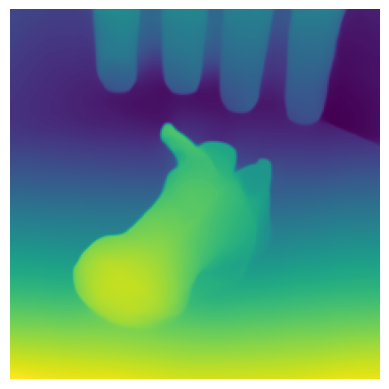

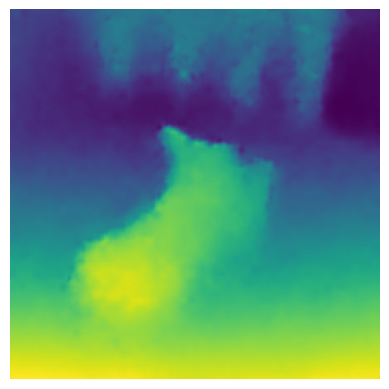

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.048827372..1.0000002].


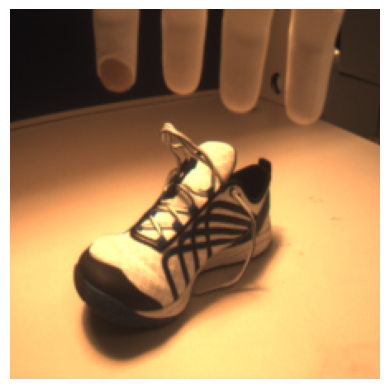

In [19]:
plot_input_reconstruction(model, dataset, -4, device='cpu')

## Depth fusion

In [ ]:
class ResNetDepthFusion(nn.Module):
    def __init__(self, autoencoder_weights='autoencoder.pt', resnet_weights='DEFAULT', latent_dim=512, num_classes=5):
        super(ResNetDepthFusion, self).__init__()

        self.resnet = models.resnet50(weights=resnet_weights)
        self.fc = nn.Linear(self.resnet.fc.in_features + latent_dim, num_classes)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.depth_autoencoder = DepthAutoencoder(latent_dim=latent_dim)
        self.depth_autoencoder.load_state_dict(torch.load(autoencoder_weights, weights_only=True))

    def forward(self, rgb, depth):
        output1 = self.resnet(rgb).squeeze(-1).squeeze(-1)
        output2 = self.depth_autoencoder(depth)[0]

        output = torch.cat((output1, output2), 1)
        output = self.fc(output)

        return output

In [11]:
model = ResNetDepthFusion().to(device)
for name, param in model.named_parameters():
        if "fc" in name:
                param.requires_grad = True
        else:
                param.requires_grad = False

In [ ]:
# Hyperparameters
lr = 1e-3
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr
)

batch_size = 64

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for rgb_maps, depth_maps, labels in tqdm(train_loader, desc="Training"):
        rgb_maps, depth_maps, labels = rgb_maps.to(device), depth_maps.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(rgb_maps, depth_maps)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")




Epoch 1/10


Training: 100%|██████████| 99/99 [04:23<00:00,  2.66s/it]


Training Loss: 1.0229, Accuracy: 58.69%

Epoch 2/10


Training:  10%|█         | 10/99 [00:29<04:20,  2.92s/it]


KeyboardInterrupt: 

## RGB only

In [19]:
model = models.resnet18(weights='DEFAULT')
model = model.to(device)

model.fc = nn.Linear(model.fc.in_features, 5)

for name, param in model.named_parameters():
        if "fc" in name:
                param.requires_grad = True
        else:
                param.requires_grad = False

In [ ]:
# Hyperparameters
lr = 1e-3
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr
)

batch_size = 64

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for rgb_maps, depth_maps, labels in tqdm(train_loader, desc="Training"):
        rgb_maps, depth_maps, labels = rgb_maps.to(device), depth_maps.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(rgb_maps)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")




Epoch 1/10


Training: 100%|██████████| 99/99 [03:45<00:00,  2.28s/it]


Training Loss: 1.0714, Accuracy: 57.67%

Epoch 2/10


Training:   2%|▏         | 2/99 [00:05<04:43,  2.92s/it]


KeyboardInterrupt: 

## Evaluation

In [21]:
class_names = ["3 jaw chuck", "key", "pinch", "power", "tool"]

### RGB only

In [29]:
import torch

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

from dataset import RGBDGraspDataset
from model import ResNet50RGBD, ResNet50RGB
from utils import get_device


datasets = [
    {
        'image_path': '../data/DeepGrasping_JustImages',
        'depth_path': '../data/DEPTH_DeepGrasping_JustImages',
        'anno_path': '../data/DeepGrasping_Anno',
        'image_subdirs': [f'{i:02}' for i in range(1, 11)],
    },
    {
        'image_path': '../data/Imagenet',
        'depth_path': '../data/DEPTH_Imagenet',
        'anno_path': '../data/Anno_ImageNet.json',
    },
    {
        'image_path': '../data/HandCam',
        'depth_path': '../data/DEPTH_HandCam',
        'anno_path': '../data/Anno_HandCam4.json',
    }
]

test_dataset = RGBDGraspDataset([datasets[2]])
device = get_device()
model = ResNet50RGB().to(device)
model.load_state_dict(torch.load('resnet50_rgb.pt', map_location=torch.device('cpu')))

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model.eval()
total = 0
correct = 0
y_true = []
y_pred = []
with torch.no_grad():
    for rgb_maps, depth_maps, labels in tqdm(test_loader, desc="Validation"):
        rgb_maps, depth_maps, labels = rgb_maps.to(device), depth_maps.to(device), labels.to(device)
    
        outputs = model(rgb_maps)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    val_accuracy = 100 * correct / total

    print(f"Validation accuracy: {val_accuracy:.2f}%")




Validation: 100%|██████████| 4/4 [00:28<00:00,  7.10s/it]

Validation accuracy: 79.60%


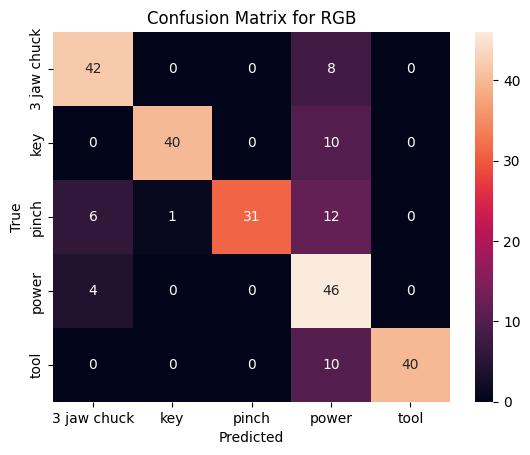

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for RGB")
plt.show()

### RGB + depth channel extension

In [31]:
import torch

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

from dataset import RGBDGraspDataset
from model import ResNet50RGBD, ResNet50RGB
from utils import get_device


datasets = [
    {
        'image_path': '../data/DeepGrasping_JustImages',
        'depth_path': '../data/DEPTH_DeepGrasping_JustImages',
        'anno_path': '../data/DeepGrasping_Anno',
        'image_subdirs': [f'{i:02}' for i in range(1, 11)],
    },
    {
        'image_path': '../data/Imagenet',
        'depth_path': '../data/DEPTH_Imagenet',
        'anno_path': '../data/Anno_ImageNet.json',
    },
    {
        'image_path': '../data/HandCam',
        'depth_path': '../data/DEPTH_HandCam',
        'anno_path': '../data/Anno_HandCam4.json',
    }
]

test_dataset = RGBDGraspDataset([datasets[2]])
device = get_device()
model = ResNet50RGBD().to(device)
model.load_state_dict(torch.load('resnet50_rgbd.pt', map_location=torch.device('cpu')))

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model.eval()
total = 0
correct = 0
y_true, y_pred = [], []
with torch.no_grad():
    for rgb_maps, depth_maps, labels in tqdm(test_loader, desc="Validation"):
        rgb_maps, depth_maps, labels = rgb_maps.to(device), depth_maps.to(device), labels.to(device)
        inputs = torch.cat((rgb_maps, depth_maps), dim=1)
    
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    val_accuracy = 100 * correct / total

    print(f"Validation accuracy: {val_accuracy:.2f}%")




Validation: 100%|██████████| 4/4 [00:27<00:00,  6.95s/it]

Validation accuracy: 62.80%


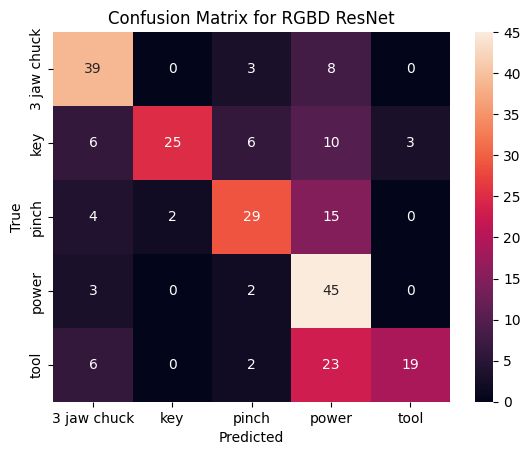

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for RGBD ResNet")
plt.show()

### Depth fusion

In [33]:
import torch

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

from dataset import RGBDGraspDataset
from model import ResNetDepthFusion
from utils import get_device


datasets = [
    {
        'image_path': '../data/DeepGrasping_JustImages',
        'depth_path': '../data/DEPTH_DeepGrasping_JustImages',
        'anno_path': '../data/DeepGrasping_Anno',
        'image_subdirs': [f'{i:02}' for i in range(1, 11)],
    },
    {
        'image_path': '../data/Imagenet',
        'depth_path': '../data/DEPTH_Imagenet',
        'anno_path': '../data/Anno_ImageNet.json',
    },
    {
        'image_path': '../data/HandCam',
        'depth_path': '../data/DEPTH_HandCam',
        'anno_path': '../data/Anno_HandCam4.json',
    }
]

test_dataset = RGBDGraspDataset([datasets[2]])
device = get_device()
model = ResNetDepthFusion().to(device)
model.load_state_dict(torch.load('depth_fusion_final.pt', map_location=torch.device('cpu')))

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model.eval()
total = 0
correct = 0
y_true, y_pred = [], []
with torch.no_grad():
    for rgb_maps, depth_maps, labels in tqdm(test_loader, desc="Validation"):
        rgb_maps, depth_maps, labels = rgb_maps.to(device), depth_maps.to(device), labels.to(device)
    
        outputs = model(rgb_maps, depth_maps)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    val_accuracy = 100 * correct / total

    print(f"Validation accuracy: {val_accuracy:.2f}%")




Validation: 100%|██████████| 4/4 [00:30<00:00,  7.57s/it]

Validation accuracy: 82.40%


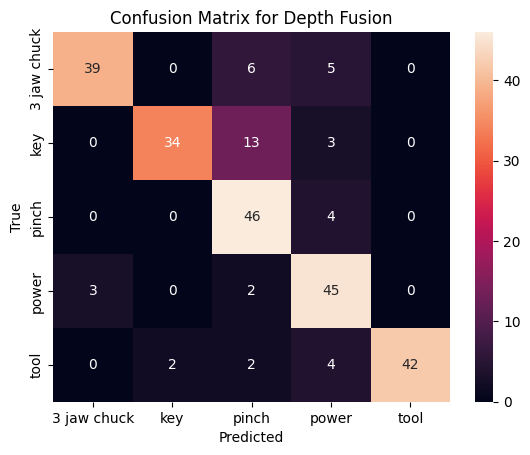

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Depth Fusion")
plt.show()